In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from itertools import product
from functools import reduce
from operator import methodcaller
from sklearn.preprocessing import StandardScaler

In [2]:
heroes = pd.read_csv('data/dictionaries/heroes.csv', index_col='id')

In [3]:
features = pd.read_csv('data/features.csv', index_col='match_id')

# Подход 1: градиентный бустинг "в лоб"

Удалены фичи, связанные с итогами матча.

In [4]:
df_1 = features.drop(['duration', 'radiant_win', 'tower_status_radiant',
                     'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1)

## Вопрос 1
**Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**

In [5]:
n = df_1.shape[0]
counter = df_1.count()
print('Пропущенные значения есть в следующих столбцах:')
pd.DataFrame({'missing_values': n - counter[counter != n]})

Пропущенные значения есть в следующих столбцах:


,missing_values
first_blood_time,19553
first_blood_team,19553
first_blood_player1,19553
first_blood_player2,43987
radiant_bottle_time,15691
radiant_courier_time,692
radiant_flying_courier_time,27479
radiant_first_ward_time,1836
dire_bottle_time,16143
dire_courier_time,676


Пропуск в признаке *first_blood_time* означает, что событие "first blood" не наступило до конца пятой минуты.  
Пропуск в признаке *dire_courier_time* означает, что предмет "courier" не был приобретён командой "dire".

In [6]:
df_1.fillna(value=0, inplace=True)

## Вопрос 2
**Как называется столбец, содержащий целевую переменную?**

Столбец, содержащий целевую переменную, называется *radiant_win*. Он указывает, победила ли команда "radiant" или проиграла.

In [7]:
target = features.radiant_win

## Вопрос 3
**Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.**

In [8]:
kfold = KFold(shuffle=True, random_state=512)
boosting = GradientBoostingClassifier(n_estimators=10, random_state=471)

Подсчёт метрики для кросс-валидации и времени работы для количества деревьев 10, 20, 30, 40, 50, 60.

In [9]:
kfold = KFold(shuffle=True, random_state=512)
grad_boost_scores = []
grad_boost_times = []
for n_estimators in range(10, 70, 10):
    start = datetime.datetime.now()
    boosting = GradientBoostingClassifier(n_estimators=n_estimators, random_state=471)
    grad_boost_scores.append(cross_val_score(boosting, df_1, target, scoring='roc_auc', cv=kfold))
    grad_boost_times.append(datetime.datetime.now() - start)

In [10]:
grad_boost_scores = list(map(np.mean, grad_boost_scores))
pd.DataFrame({'score': grad_boost_scores, 'time, sec': map(methodcaller('total_seconds'), grad_boost_times)}, index=range(10, 70, 10))

,score,"time, sec"
10,0.664513,132.511580
20,0.682591,255.360794
30,0.689441,389.976364
40,0.694353,510.419979
50,0.697628,646.997368
60,0.700355,744.602589


Время кросс-валидации для 30 деревьев равно 6 минут 53.767331 секунд.  
Качество равно 0.689441.

## Вопрос 4
**Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**

В данном случае можно попробовать использовать больше, так как качество модели с увеличением количества деревьев только увеличивалось.  
Для ускорения обучения деревьев можно увеличить степень регуляризации: уменьшить максимальную глубину деревьев, увеличить гиперпараметр *learning rate* самого бустинга или использовать стохастический градиентный бустинг.

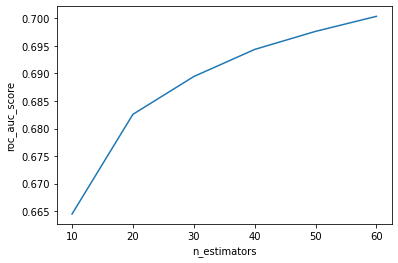

In [11]:
plt.plot(range(10, 70, 10), grad_boost_scores)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.show()

# Подход 2: логистическая регрессия

## Вопрос 1
**Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**

In [12]:
C_param_values = 10.**np.arange(-5, 5)

In [13]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_1), index=df_1.index, columns=df_1.columns)

In [14]:
log_reg_1_scores = []
log_reg_1_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_1_scores.append(cross_val_score(log_reg, df_scaled, target, scoring='roc_auc', cv=kfold))
    log_reg_1_times.append(datetime.datetime.now() - start)

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [15]:
log_reg_1_scores = np.array(list(map(np.mean, log_reg_1_scores)))
pd.DataFrame({'score': log_reg_1_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_1_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.695006,4.645815
0.00010,0.711085,5.606818
0.00100,0.716015,9.046581
0.01000,0.716187,12.890351
0.10000,0.716163,13.233933
1.00000,0.716158,13.233931
10.00000,0.716158,13.406597
100.00000,0.716158,13.343301
1000.00000,0.716158,13.218307
10000.00000,0.716158,13.452678


График качества модели от параметра C.

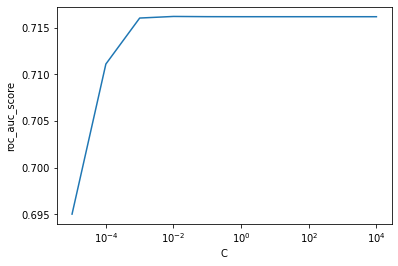

In [16]:
plt.plot(C_param_values, log_reg_1_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [17]:
C_param_values[log_reg_1_scores.argmax()]

0.01

Максимальное качество

In [18]:
log_reg_1_scores.max()

0.7161868008507322

Таким образом, качество логистической регрессии 0.716187 получилось выше качества градиентного бустинга 0.700355 на 60 деревьях. Это может быть связано с тем, что количество деревьев недостаточное, ведь качество модели только увеличивалось. Также это может быть связано с качеством данных. Например, категориальные признаки были использованы как числовые, использован признак время начала. Логистическая регрессия работает быстрее в 811.2/12.5 = 64.896 раз по сравнению с градиентным бустингом на 60 деревьях.

## Вопрос 2
**Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?**

In [19]:
dropped_features = ['lobby_type'] + [f'{team}{n}_hero' for team, n in product(['r', 'd'], range(1, 6))]

In [20]:
df_2 = df_scaled.drop(dropped_features, axis=1)

In [21]:
log_reg_2_scores = []
log_reg_2_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_2_scores.append(cross_val_score(log_reg, df_2, target, scoring='roc_auc', cv=kfold))
    log_reg_2_times.append(datetime.datetime.now() - start)

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [22]:
log_reg_2_scores = np.array(list(map(np.mean, log_reg_2_scores)))
pd.DataFrame({'score': log_reg_2_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_2_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.694947,4.772420
0.00010,0.711086,5.171600
0.00100,0.716059,8.577838
0.01000,0.716234,12.858946
0.10000,0.716213,13.024294
1.00000,0.716210,13.408189
10.00000,0.716209,12.838018
100.00000,0.716209,13.513581
1000.00000,0.716209,14.133208
10000.00000,0.716209,13.347745


График качества модели от параметра C.

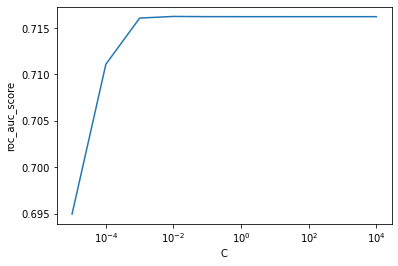

In [23]:
plt.plot(C_param_values, log_reg_2_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [24]:
C_param_values[log_reg_2_scores.argmax()]

0.01

Максимальное качество

In [25]:
log_reg_2_scores.max()

0.7162342365982566

Качество стало 0.716234, оно увеличилось ненамного — на 0.716234-0.716187=0.000047=4.7e-5. Это связано с тем, что веса удаленных признаков в логистической регрессии было небольшим. 

## Вопрос 3
**Сколько различных идентификаторов героев существует в данной игре?**

In [26]:
len(heroes.index)

112

Значит, всего в данной игре 112 различных героев.

## Вопрос 4
**Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?**

In [27]:
N = len(heroes.index)
X_pick = np.zeros((df_1.shape[0], N))
for i, match_id in enumerate(df_1.index):
    for p in range(5):
        X_pick[i, df_1.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, df_1.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [28]:
df_3 = df_2.copy()

In [29]:
df_3[[f'hero_{i}' for i in heroes.index]] = X_pick

In [30]:
log_reg_3_scores = []
log_reg_3_times = []
for C in C_param_values:
    start = datetime.datetime.now()
    log_reg = LogisticRegression(random_state=192, C=C)
    log_reg_3_scores.append(cross_val_score(log_reg, df_3, target, scoring='roc_auc', cv=kfold))
    log_reg_3_times.append(datetime.datetime.now() - start)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Качество модели и время обучения на кроссвалидации в зависимости от параметра C.

In [31]:
log_reg_3_scores = np.array(list(map(np.mean, log_reg_3_scores)))
pd.DataFrame({'score': log_reg_3_scores, 'time, sec': map(methodcaller('total_seconds'), log_reg_3_times)}, index=C_param_values)

,score,"time, sec"
0.00001,0.699011,7.088208
0.00010,0.724767,8.812205
0.00100,0.746009,18.567501
0.01000,0.751485,31.200797
0.10000,0.751720,38.881069
1.00000,0.751706,39.248072
10.00000,0.751707,39.396234
100.00000,0.751706,40.477075
1000.00000,0.751706,39.097379
10000.00000,0.751706,39.827926


График качества модели от параметра C.

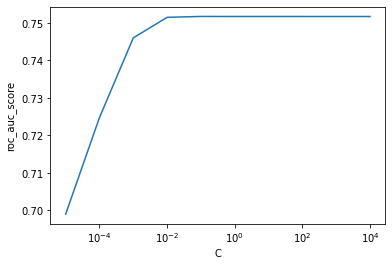

In [32]:
plt.plot(C_param_values, log_reg_3_scores)
plt.xlabel('C')
plt.ylabel('roc_auc_score')
plt.xscale('log')
plt.show()

Значение параметра C, при котором качество достигает максимума.

In [33]:
C_param_values[log_reg_3_scores.argmax()]

0.1

Максимальное качество

In [34]:
log_reg_3_scores.max()

0.7517199228284378

Качество на новых данных равно 0.751520, достигается при C=0.1. Оно несомненно увеличилось. Это связано с тем, что категориальная переменная теперь закодирована и используется именно как категориальная, а не числовая.

## Вопрос 5
**Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?**

In [35]:
features_test = pd.read_csv('data/features_test.csv', index_col='match_id')

Преобразование данных, как и тренировочных

In [36]:
features_test.fillna(value=0, inplace=True)
test_df_scaled = pd.DataFrame(StandardScaler().fit_transform(features_test), index=features_test.index, columns=features_test.columns)

In [37]:
N = len(heroes.index)
X_pick_test = np.zeros((features_test.shape[0], N))
for i, match_id in enumerate(features_test.index):
    for p in range(5):
        X_pick_test[i, features_test.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick_test[i, features_test.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [38]:
test_df_scaled[[f'hero_{i}' for i in heroes.index]] = X_pick_test
test_df_scaled.drop(dropped_features, axis=1, inplace=True)

Тренировка лучшей модели

In [39]:
log_reg_best = LogisticRegression(random_state=192, C=0.1)

In [40]:
log_reg_best.fit(df_3, target)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=192)

In [41]:
predicted = log_reg_best.predict_proba(test_df_scaled)

In [42]:
predicted_r_win = predicted[:, 1]

Минимальное значение прогноза

In [43]:
predicted_r_win.min()

0.008583784557471335

Максимальное значение прогноза

In [44]:
predicted_r_win.max()

0.9964598059905446

Минимальное значение прогноза - 0.00858  
Максимальное значение прогноза - 0.99646

# My experiments

I tried to fill nans with -10000 and 10000 as outliers, 0 and the mean values as default. I used logistic regression, gradient and adaptive boostings, kNN method, SGD and stacking. Also I reduced the dimension of the data in case filling nans with -10000.

In [1]:
import datetime
from functools import reduce
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import json

In [2]:
heroes = pd.read_csv('data/dictionaries/heroes.csv', index_col='id')
lobbies = pd.read_csv('data/dictionaries/lobbies.csv', index_col='id')
features = pd.read_csv('data/features.csv', index_col='match_id')

In [3]:
features.lobby_type.value_counts()

1    55962
7    28550
0    12718
Name: lobby_type, dtype: int64

In [4]:
class StackingEnsemble:
    """
    Stacking ensemble
    ---------
    layers: list of lists of classifiers
    
    It consists of the lists of classifiers used in
    layers for stacking. The last layer must consist of 1 classifier
    otherwise the exception will be thrown"""
    def __init__(self, layers):
        assert len(layers[-1]) == 1
        assert type(layers) is list
        assert all(map(lambda layer: type(layer) is list, layers))
        self.layers = []
        for layer in layers:
            self.layers.append(layer.copy())
        self.n_layers = len(self.layers)
    
    def fit(self, X, y):
        current_X = X.copy()
        current_y = y.copy()
        for i, layer in enumerate(self.layers):
            if i == self.n_layers - 1:
                layer[0].fit(current_X, current_y)
                break
            X_train, X_test, y_train, y_test = train_test_split(current_X, current_y,
                                                                train_size=len(current_X) // (self.n_layers - i))
            for clf in layer:
                clf.fit(X_train, y_train)
            current_X = pd.DataFrame({
                k: clf.predict(X_test)
                for k, clf in enumerate(layer)
            })
            current_y = y_test
    
    def predict(self, X):
        current_X = X.copy()
        for layer in self.layers:
            current_X = pd.DataFrame({
                k: clf.predict(current_X)
                for k, clf in enumerate(layer)
            })
        return current_X
    
    def predict_proba(self, X):
        current_X = X.copy()
        for layer in self.layers:
            current_X = pd.DataFrame({
                k: clf.predict_proba(current_X)[:, 1]
                for k, clf in enumerate(layer)
            })
        return current_X

In [5]:
X = pd.read_csv('data/X.csv', index_col='match_id')
y = pd.read_csv('data/y.csv', index_col='match_id')

In [6]:
print([i for i in heroes.index if (X[f'r_hero_{i}'] == 0).all()])

[108, 109, 111, 113]


In [7]:
print([i for i in lobbies.index if (X[f'lobby_type_{i}'] == 0).all()])

[-1, 2, 3, 4, 5, 6, 8]


So these columns contains only zeros. They can be removed

In [8]:
columns_to_drop = ['start_time'] + [f'lobby_type_{k}' for k in [-1, 2, 3, 4, 5, 6, 8]] +\
                                        [f'{team}_hero_{hero}' for team, hero in product(['r', 'd'], [108, 109, 111, 113])]

In [9]:
X.drop(columns=columns_to_drop, inplace=True)

In [10]:
X_with_nans = X.replace(to_replace=-10000, value=np.nan)

In [11]:
X_with_nans.head()

,first_blood_time,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,...,d_team_gold,d_team_lh,d_team_kills,d_team_deaths,d_team_items,lobby_type_0,lobby_type_1,lobby_type_7,was_first_blood,first_blood_r
match_id,,,,,,,,,,,,,,,,,,,,,
0,7.0,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,...,5021,52,1,0,33,0.0,0.0,1.0,1.0,0.0
1,54.0,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,...,5505,43,2,1,41,1.0,0.0,0.0,1.0,0.0
2,224.0,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,...,5786,70,1,2,42,0.0,0.0,1.0,1.0,1.0
3,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,...,4729,51,0,0,37,0.0,1.0,0.0,0.0,0.0
4,-21.0,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,...,5068,46,1,3,40,0.0,0.0,1.0,1.0,0.0


## Common experiments

In [12]:
cases = ['-10000', '0', '10000', 'mean']
fill_nan_values = [-10000, 0, 10000, X_with_nans.mean()]
models = ['ada', 'lgbm', 'knn', 'log_reg']

all_models_info = {
    case: {
        model: {
            'tuned_params': {},
            'params': {},
            'scores': [],
            'eval_time_values': []
        } for model in models
    } for case in cases
}

now = datetime.datetime.now

for fill_nan_value, case in zip(fill_nan_values, cases):

    print('Fill nans with', case, '\n')
    
    X = X_with_nans.fillna(fill_nan_value)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=148)
    y_train, y_test = y_train.radiant_win, y_test.radiant_win

    # Light GBM

    print('LightGBM\n')
    n_trees = 2000
    n_estimators_to_check_scores = np.arange(100, n_trees + 1, 100)
    n_estimators_values = n_estimators_to_check_scores
    lgbm_scores = {}
    best_lgbm_n_estimators = {}
    eval_time_values = {}
    max_depths = range(1, 7)

    for max_depth in max_depths:

        print(f'max_depth: {max_depth}')
        start = now()

        lgbm = LGBMClassifier(n_estimators=n_trees, max_depth=max_depth)
        lgbm.fit(X_train, y_train)

        scores = np.array([roc_auc_score(y_test, lgbm.predict_proba(X_test, num_iteration=i)[:, 1])
                           for i in n_estimators_to_check_scores])
        
        eval_time_values[max_depth] = now() - start
        best_score = scores.max()
        
        lgbm_scores[max_depth] = scores.max()
        best_lgbm_n_estimators[max_depth] = n_estimators_values[scores.argmax()]
        print('score:', scores.max(), '\n')

    all_models_info[case]['lgbm'] = {
        'tuned_params': {'max_depth': max_depths},
        'params': {'n_estimators': best_lgbm_n_estimators},
        'scores': list(lgbm_scores.values()),
        'eval_time_values': list(eval_time_values.values())
    }
    print('___________________\n')


#################################

    # AdaBoost

    print('AdaBoost\n')
    n_trees = 1000
    n_estimator_values = np.arange(1, n_trees + 1)
    ada_scores = {}
    best_ada_n_estimators = {}
    eval_time_values = {}
    max_depths = range(1, 4)

    for max_depth in max_depths:

        print(f'max_depth: {max_depth}')
        start = now()

        ada_boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth),
                                          n_estimators=n_trees)
        ada_boosting.fit(X_train, y_train)

        scores = np.array([roc_auc_score(y_test, predicted[:, 1])
                           for predicted in ada_boosting.staged_predict_proba(X_test)])
        
        eval_time_values[max_depth] = now() - start
        ada_scores[max_depth] = scores.max()
        best_ada_n_estimators[max_depth] = n_estimator_values[scores.argmax()]
        print('score:', scores.max(), '\n')

    all_models_info[case]['ada'] = {
        'tuned_params': {'max_depth': max_depths},
        'params': {'n_estimators': best_ada_n_estimators},
        'scores': list(ada_scores.values()),
        'eval_time_values': list(eval_time_values.values())
    }
    print('___________________\n')

#################################


    # scaling the data for knn classifier logistic regression
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    # knn classifier
    print('knn classifier\n')
    n_neighbors_values = np.arange(1000, 16000, 3000)
    knn_scores = {}
    eval_time_values = {}

    for n_neighbors in n_neighbors_values:
        print('n_neighbors:', n_neighbors)
        start = now()
        
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(scaled_X_train, y_train)
        knn_scores[n_neighbors] = roc_auc_score(
            y_test, knn.predict_proba(scaled_X_test)[:, 1])
        
        eval_time_values[max_depth] = now() - start
        
        print('score:', scores.max(), '\n')

    all_models_info[case]['knn'] = {
        'tuned_params': {'knn': n_neighbors_values},
        'scores': list(knn_scores.values()),
        'eval_time_values': list(eval_time_values.values())
    }
    print('___________________\n')

#################################

    # logistic regression
    
    print('logistic regression\n')
    start = now()
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(scaled_X_train, y_train)
    score = roc_auc_score(y_test, log_reg.predict_proba(scaled_X_test)[:, 1])
    print('score:', score, '\n')
    
    all_models_info[case]['log_reg'] = {
        'tuned_params': {},
        'scores': [score],
        'eval_time_values': [now() - start]
    }
    print('####################################\n')    

Fill nans with -10000 

LightGBM

max_depth: 1
score: 0.7524443465484303 

max_depth: 2
score: 0.7543545228126283 

max_depth: 3
score: 0.7531357456815493 

max_depth: 4
score: 0.7513837859944169 

max_depth: 5
score: 0.7513464165036298 

max_depth: 6
score: 0.7505946838615755 

___________________

AdaBoost

max_depth: 1
score: 0.751156582032573 

max_depth: 2
score: 0.7445449626313037 

max_depth: 3
score: 0.7354272358657289 

___________________

knn classifier

n_neighbors: 1000
score: 0.7354272358657289 

n_neighbors: 4000
score: 0.7354272358657289 

n_neighbors: 7000
score: 0.7354272358657289 

n_neighbors: 10000
score: 0.7354272358657289 

n_neighbors: 13000
score: 0.7354272358657289 

___________________

logistic regression

score: 0.7545974774640416 

####################################

Fill nans with 0 

LightGBM

max_depth: 1
score: 0.7526200191688116 

max_depth: 2
score: 0.7547203900408824 

max_depth: 3
score: 0.7537650106216529 

max_depth: 4
score: 0.7521190900423071

In [19]:
print(json.dumps(all_models_info, default=str, indent=2))

{
  "-10000": {
    "ada": {
      "tuned_params": {
        "max_depth": "range(1, 4)"
      },
      "params": {
        "n_estimators": {
          "1": "816",
          "2": "96",
          "3": "31"
        }
      },
      "scores": [
        0.751156582032573,
        0.7445449626313037,
        0.7354272358657289
      ],
      "eval_time_values": [
        "0:19:18.435356",
        "0:32:18.584246",
        "0:45:16.099661"
      ]
    },
    "lgbm": {
      "tuned_params": {
        "max_depth": "range(1, 7)"
      },
      "params": {
        "n_estimators": {
          "1": "2000",
          "2": "1800",
          "3": "600",
          "4": "600",
          "5": "400",
          "6": "300"
        }
      },
      "scores": [
        0.7524443465484303,
        0.7543545228126283,
        0.7531357456815493,
        0.7513837859944169,
        0.7513464165036298,
        0.7505946838615755
      ],
      "eval_time_values": [
        "0:00:46.512307",
        "0:00:57.58939

In [21]:
f = open('all_models_info.txt', 'w')
f.write(json.dumps(all_models_info, default=str, indent=2))
f.close()

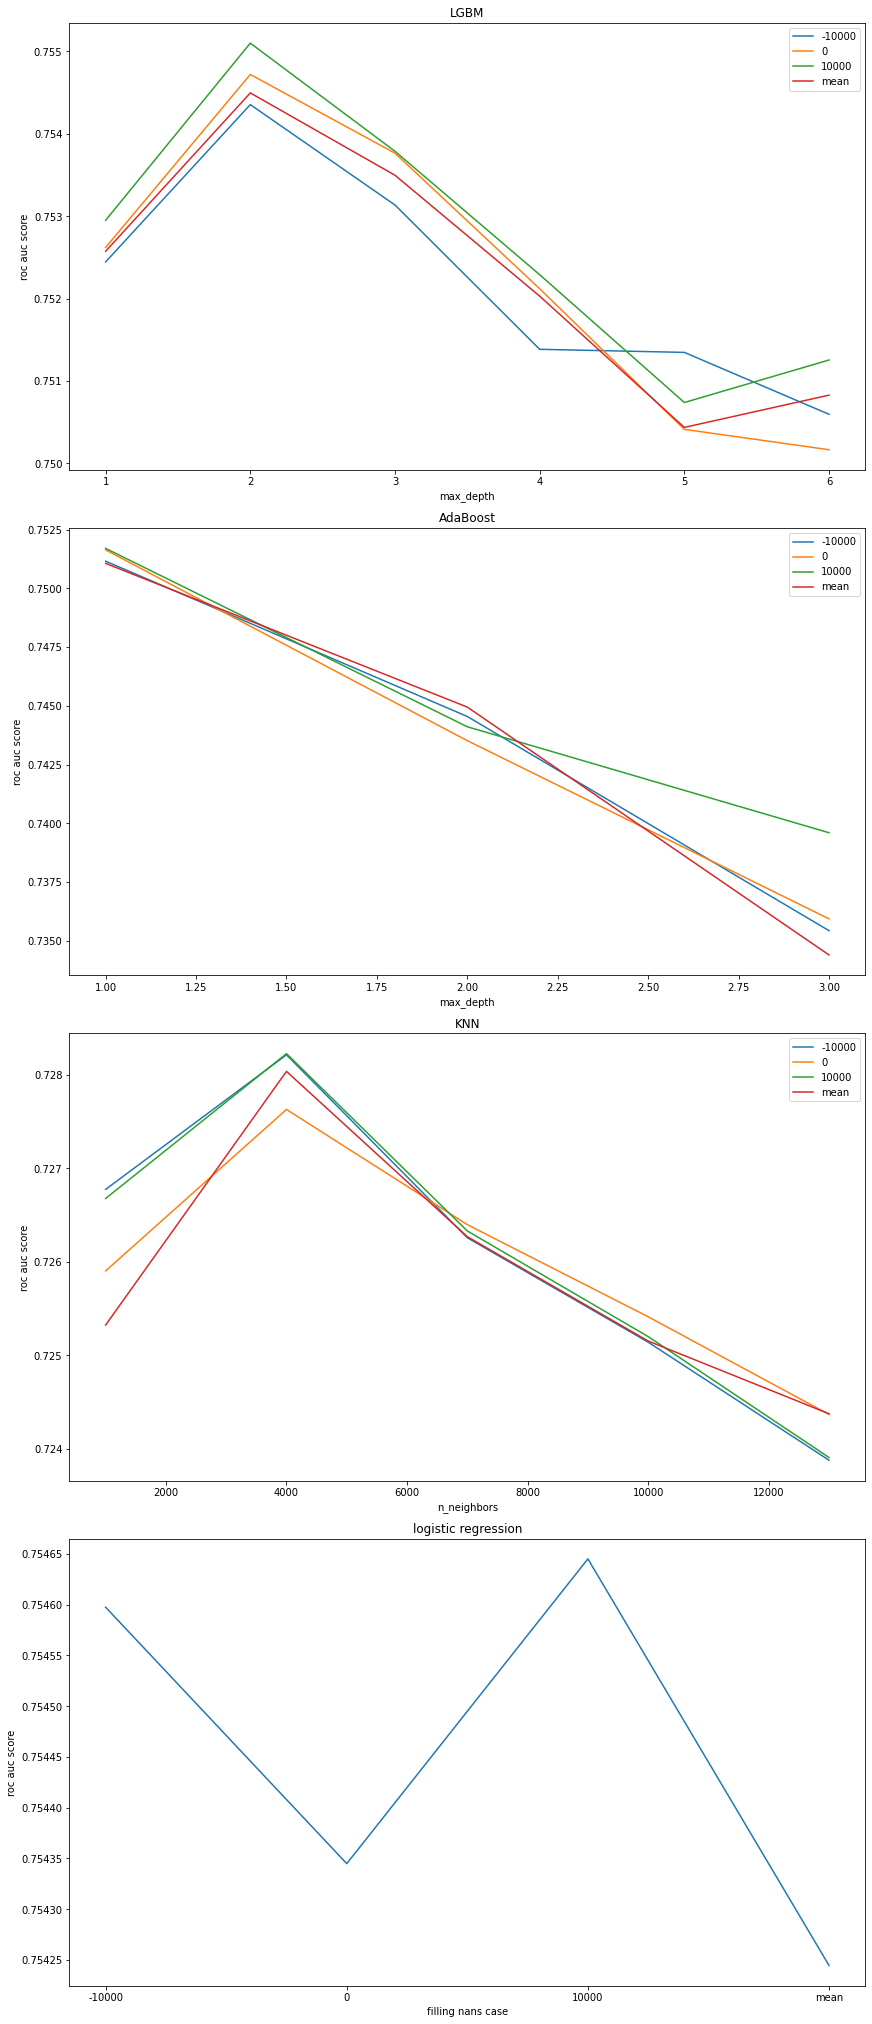

In [69]:
fig, axes = plt.subplots(4, 1,
                         figsize=(12, 7 * 4),
                         constrained_layout=True)
for case in cases:
    
    case_info = all_models_info[case]
    
    lgbm_info = case_info['lgbm']
    ada_info = case_info['ada']
    knn_info = case_info['knn']
    log_reg_info = case_info['log_reg']
    
    for i, model_info, model_name in zip([0, 1], [lgbm_info, ada_info], ['LGBM', 'AdaBoost']):
        axes[i].set_title(model_name)
        axes[i].plot(model_info['tuned_params']['max_depth'], model_info['scores'])
        axes[i].set_xlabel('max_depth')
        axes[i].set_ylabel('roc auc score')
        axes[i].legend(cases)

    axes[2].set_title('KNN')
    axes[2].plot(knn_info['tuned_params']['knn'], knn_info['scores'])
    axes[2].set_xlabel('n_neighbors')
    axes[2].set_ylabel('roc auc score')
    axes[2].legend(cases)

axes[3].set_title('logistic regression')
axes[3].plot(range(4), [all_models_info[case]['log_reg']['scores'][0] for case in cases])
axes[3].set_xticks(ticks=range(4))
axes[3].set_xticklabels(cases)
axes[3].set_xlabel('filling nans case')
axes[3].set_ylabel('roc auc score')

plt.show()

In [87]:
scores_df = pd.DataFrame({'score': [max(all_models_info[case][model]['scores']) for case, model in product(cases, models)],
                         'case': [case for case, model in product(cases, models)],
                          'model': [model for case, model in product(cases, models)]}).set_index(['model', 'case'])
scores_df.sort_values(by='score')

score
model   case            
knn     0       0.727628
        mean    0.728035
        -10000  0.728213
        10000   0.728225
ada     mean    0.751063
        -10000  0.751157
        0       0.751637
        10000   0.751702
log_reg mean    0.754245
        0       0.754345
lgbm    -10000  0.754355
        mean    0.754496
log_reg -10000  0.754597
        10000   0.754645
lgbm    0       0.754720
        10000   0.755101

In [106]:
from operator import methodcaller

In [109]:
best_lgbm_info = all_models_info['10000']['lgbm'].copy()
best_lgbm_info.update({
    'tuned_params': best_lgbm_info['tuned_params']['max_depth'],
    'params': best_lgbm_info['params']['n_estimators'].values(),
    'eval_time_values': list(map(methodcaller('total_seconds'), best_lgbm_info['eval_time_values']))
}
)
pd.DataFrame(best_lgbm_info).rename(columns={'tuned_params': 'max_depth', 'params': 'n_estimators'})

,max_depth,n_estimators,scores,eval_time_values
0,1,2000,0.752950,42.425874
1,2,1700,0.755101,56.565521
2,3,600,0.753788,74.756141
3,4,600,0.752290,90.494412
4,5,300,0.750738,115.497866
5,6,300,0.751254,118.440026


The max score is for lgbm model in case filling value equals 10000, the max_depth parameter of model equals 2 and n_estimators equals 1700.  
The max score is 0.755101.

## Stacking

In [112]:
X = X_with_nans.fillna(10000)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=148)
y_train, y_test = y_train.radiant_win, y_test.radiant_win

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [113]:
stacking = StackingEnsemble(
    layers=[
        [KNeighborsClassifier(n_neighbors=4000),
         LGBMClassifier(max_depth=2, n_estimators=1000),
         LogisticRegression(max_iter=1000),
         AdaBoostClassifier(n_estimators=500)]
        for k in range(5)] + [[LogisticRegression(max_iter=1000)]])

stacking.fit(scaled_X_train, y_train)
roc_auc_score(y_test, stacking.predict_proba(scaled_X_test))

0.7445651461813872

The score is lower than the score of lgbm.